<a href="https://colab.research.google.com/github/AlexisD29/Field-Mapping/blob/main/Linear_Regression_station69%2Cm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # that's the location your drive will be mounted

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_hdf("/content/drive/My Drive/SULI/run3997_.h5", key='raw')

# we need to know the positions of the fixed probe stations:
import numpy as np
fp_positions = np.array([350.17, 354.33, 358.84,   4.34,   9.33,  14.23,  20.2 ,  23.32,
        29.33,  34.33,  39.33,  43.31,  50.2 ,  53.31,  59.34,  64.33,
        69.34,  73.3 ,  80.17,  83.32,  89.31,  94.33,  99.31, 103.3 ,
       110.19, 113.31, 119.34, 124.32, 129.3 , 133.27, 140.21, 143.38,
       149.34, 154.33, 159.36, 163.31, 170.19, 173.39, 179.36, 184.35,
       189.36, 193.31, 200.17, 203.38, 209.34, 214.31, 219.34, 223.32,
       230.22, 233.42, 239.36, 244.34, 249.38, 253.34, 260.2 , 263.47,
       269.35, 274.34, 279.38, 283.41, 290.19, 293.37, 299.34, 304.31,
       309.34, 313.29, 320.19, 323.41, 329.33, 334.35, 339.35, 343.41])

In [ ]:
station = 40
veto_extent = 25 # studies have shown that the effect of the trolley is that large
offset = -1.5 # the center of the trolley footprint is 1.5deg off from its position

veto_low = (fp_positions[station] + offset - veto_extent/2)%360
veto_high = (fp_positions[station] + offset + veto_extent/2)%360

if veto_low > veto_high:
    veto_low, veto_high = veto_high, veto_low

required_low =  (fp_positions[station-1] + fp_positions[station])/2. # that's the range the trolley and the fixed probes will be "synchronized"
required_high = (fp_positions[station+1] + fp_positions[station])/2.

print("Station %i at %.2fdeg: veto from %.2fdeg to %.2fdeg" % (station, fp_positions[station], veto_low, veto_high))
veto     = (df['tr_phi']>veto_low)     & (df['tr_phi']<veto_high)
required = (df['tr_phi']>required_low) & (df['tr_phi']<required_high)

Station 40 at 189.36deg: veto from 175.36deg to 200.36deg


In [ ]:
# Let's use some data before and after the "veto-range" for our linear interpolation/regression
regression_data_extent = 1.0 # degrees
regression_data = ((df['tr_phi'] < veto_low) & (df['tr_phi'] > veto_low - regression_data_extent) |
              (df['tr_phi'] > veto_high) & (df['tr_phi'] < veto_high + regression_data_extent) )

In [ ]:
df.head()

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,fp37,fp38,fp39,...,"st68,m2","st68,m3","st68,m4","st68,m5","st68,m6","st69,m1","st69,m2","st69,m3","st69,m4","st69,m5","st69,m6","st70,m1","st70,m2","st70,m3","st70,m4","st70,m5","st70,m6","st71,m1","st71,m2","st71,m3","st71,m4","st71,m5","st71,m6","tr,m1","tr,m2","tr,m3","tr,m4","tr,m5","tr,m6","tr,m7","tr,m8","tr,m9","tr,m10","tr,m11","tr,m12","tr,m13","tr,m14","tr,m15","tr,m16","tr,m17"
2018-04-25 02:47:01-05:00,45121.330222,50479.467168,54883.298883,49532.156971,61949.422202,67457.838898,35134.234975,50981.818215,56457.686283,44877.933681,56381.670350,62441.511522,42528.322900,52159.577570,56774.837280,45416.872601,55231.351281,61257.312516,56543.538987,53111.558295,47246.710239,59702.8367,55252.588545,48226.179585,60242.783514,57671.617712,43526.228728,73001.863454,58836.588689,53202.050951,62991.722845,58001.482950,49342.898686,65705.331816,65822.074547,61187.493671,45581.876449,53002.662900,54985.035984,51142.422216,...,-352.018793,-234.845072,-1518.594025,923.698755,4364.645516,55219.433056,-4030.503043,325.367391,-2342.346376,1668.183757,2422.546008,53398.931580,-1494.902493,718.535333,1152.192237,2409.702683,488.183948,52991.419151,-4184.577102,1022.529421,1846.572987,790.585464,-59.762412,53061.072294,68.444453,151.543175,422.701288,19.859639,-107.471424,81.828103,-82.549399,-56.279400,45.178420,198.879479,-60.421582,0.0,-159.264002,337.205102,0.0,0.0
2018-04-25 02:47:02-05:00,45120.400006,50479.834853,54883.737490,49558.994882,61927.206768,67515.186699,35130.070020,50982.008002,56458.025298,44873.804767,56376.797198,62441.239734,42529.516273,52158.777272,56774.833006,45447.533343,55281.002225,61283.829701,56543.754997,53113.097230,47248.370650,59702.8367,55202.594072,48218.611242,60241.311816,57672.338985,43525.513139,73071.310137,58834.271211,53196.885047,62999.455002,58002.264946,49343.333997,65693.541887,65770.910332,61293.784587,45581.937049,53002.506969,54985.277831,51142.256443,...,-352.253887,-234.870338,-1518.444847,925.865927,4363.103590,55218.838744,-4024.248546,324.207521,-2343.726953,1670.064408,2422.779367,53399.336760,-1495.082470,718.316510,1152.127106,2411.297955,490.185519,52992.013553,-4186.359995,1022.381366,1846.598064,791.069579,-58.505594,53061.129354,68.504032,151.781238,422.496123,20.120751,-108.192581,81.581832,-82.878718,-55.285620,19.247051,151.018594,-61.880669,0.0,-114.542080,260.264430,0.0,0.0
2018-04-25 02:47:03-05:00,45119.566030,50480.222045,54884.005555,49564.024494,61932.965307,67596.965136,35128.574129,50983.186427,56457.887330,44870.822528,56367.256956,62426.082374,42526.967047,52160.988071,56773.646079,45436.596953,55262.590584,61287.274618,56543.454747,53113.078230,47247.304162,59702.8367,55216.960456,48208.417976,60245.846244,57672.480179,43527.346795,72988.914030,58833.394491,53195.649227,63003.533878,58001.875717,49342.263328,65687.072148,65758.355086,61316.359671,45581.265014,53003.142626,54985.367428,51142.217340,...,-352.538114,-234.932883,-1518.404625,930.147072,4358.586911,55217.170833,-4020.776837,324.341081,-2343.789727,1672.567667,2419.869304,53399.031349,-1494.937758,718.478096,1152.084168,2412.030412,488.875672,52991.215939,-4185.575917,1022.968742,1846.464924,790.963848,-59.321095,53060.829747,68.546106,151.516287,422.303544,20.147102,-107.999295,82.018587,-82.558416,-54.427985,7.373257,155.574484,-62.888454,0.0,-95.208539,267.075706,0.0,0.0
2018-04-25 02:47:04-05:00,45119.769818,50479.854368,54883.425171,49596.330313,61924.389375,67696.834766,35130.326168,50983.046675,56457.559901,44860.166354,56369.181238,62433.414570,42524.375795,52160.340803,56773.513372,45411.473142,55208.895160,61310.146711,56542.927726,53112.671872,47246.385987,59702.8367,55240.834108,48203.947527,60250.799371,57672.272490,43530.186091,72928.260960,58830.969896,53195.330082,63003.982866,58001.498164,49340.896528,6569

(315.33, 340.33)

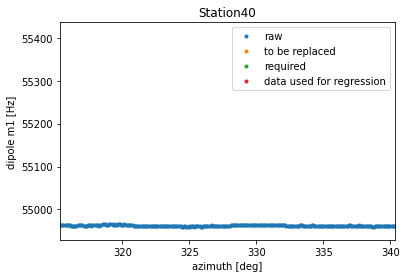

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(df['tr_phi'], df['st%i,m1' % station],'.', label="raw")
plt.plot(df['tr_phi'][veto], df['st%i,m1' % station][veto],'.', label = "to be replaced")
plt.plot(df['tr_phi'][required], df['st%i,m1' % station][required],'.', label = "required")
plt.plot(df['tr_phi'][regression_data], df['st%i,m1' % station][regression_data],'.', label = "data used for regression")
plt.xlabel("azimuth [deg]")
plt.ylabel("dipole m1 [Hz]")
plt.legend()
plt.title("Station%i" % station)
plt.xlim([315.33,340.33])

In [ ]:
df[veto].index

DatetimeIndex(['2018-04-25 02:59:48-05:00', '2018-04-25 02:59:49-05:00',
               '2018-04-25 02:59:50-05:00', '2018-04-25 02:59:51-05:00',
               '2018-04-25 02:59:52-05:00', '2018-04-25 02:59:53-05:00',
               '2018-04-25 02:59:54-05:00', '2018-04-25 02:59:55-05:00',
               '2018-04-25 02:59:56-05:00', '2018-04-25 02:59:57-05:00',
               ...
               '2018-04-25 03:04:38-05:00', '2018-04-25 03:04:39-05:00',
               '2018-04-25 03:04:40-05:00', '2018-04-25 03:04:41-05:00',
               '2018-04-25 03:04:42-05:00', '2018-04-25 03:04:43-05:00',
               '2018-04-25 03:04:44-05:00', '2018-04-25 03:04:45-05:00',
               '2018-04-25 03:04:46-05:00', '2018-04-25 03:04:47-05:00'],
              dtype='datetime64[ns, US/Central]', length=300, freq='S')

Produce a linear fit between the "data used for regression" points. We are going to use a linear regression.

In [ ]:
from sklearn.linear_model import LinearRegression

regression_data_extent = 1.0

times_regression_data = df[regression_data].index.astype('i8').values.reshape(-1,1)
y = df[regression_data]['st%i,m1'% station].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(times_regression_data, y)

veto_times = df[veto].index.astype('i8').values.reshape(-1,1)
prediction_veto = reg.predict(veto_times)

The linear model is: Y = -2.0664e+06 + 1.3914e-12X


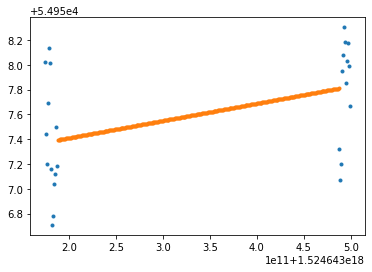

In [ ]:
plt.plot(times_regression_data, y,'.', label="data used for regression")
plt.plot(veto_times, prediction_veto,'.', label="prediction from regression")
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

(175.36, 200.36)

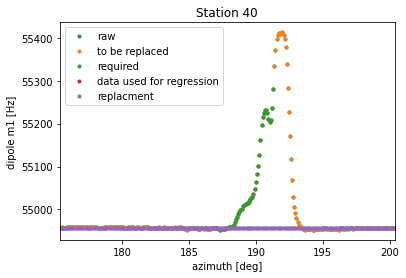

In [ ]:
plt.plot(df['tr_phi'], df['st%i,m1' % station],'.', label="raw")
plt.plot(df['tr_phi'][veto], df['st%i,m1' % station][veto],'.', label = "to be replaced")
plt.plot(df['tr_phi'][required], df['st%i,m1' % station][required],'.', label = "required")
plt.plot(df['tr_phi'][regression_data], df['st%i,m1' % station][regression_data],'.', label = "data used for regression")
plt.plot(df['tr_phi'][veto], prediction_veto,'.', label = "replacment")
plt.xlabel("azimuth [deg]")
plt.ylabel("dipole m1 [Hz]")
plt.legend()
plt.title("Station %i" % station)
plt.xlim([175.36,200.36])

Text(0.5, 0, 'Date Times of Trolley Run')

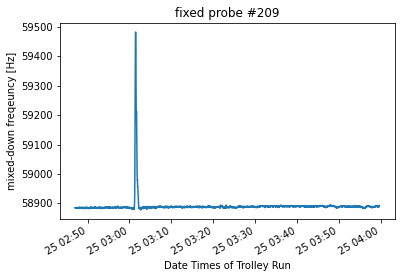

In [ ]:
import matplotlib.pyplot as plt
df["fp209"].plot()
plt.title("fixed probe #209")
plt.ylabel("mixed-down freqeuncy [Hz]")
plt.xlabel('Date Times of Trolley Run')